## Introdução
Nesta postagem do blog, você aprenderá sobre a ideia básica por trás da otimização do portfólio de Markowitz e como fazê-lo em Python. Em seguida, mostraremos um backtest simples que reequilibra seu portfólio de uma forma Markowitz-ótima. Esperamos que você goste e o considere esclarecedor.

Começaremos usando dados aleatórios e salvaremos dados de ações reais para mais tarde. Esperamos que isso ajude você a ter uma noção de como usar modelagem e simulação para melhorar sua compreensão dos conceitos teóricos. Não se esqueça de que a habilidade de um algo-trader é colocar modelos matemáticos em código, e este exemplo é uma ótima prática.

Vamos começar importando alguns módulos dos quais precisamos mais tarde e produzindo uma série de retornos normalmente distribuídos. `cvxopt` é um solucionador convexo que usaremos para a otimização do portfólio.

## Simulações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

Suponha que temos 4 ativos, cada um com uma série de retornos de comprimento 1000. Podemos usar `numpy.random.randn` para amostrar retornos de uma distribuição normal.

In [2]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

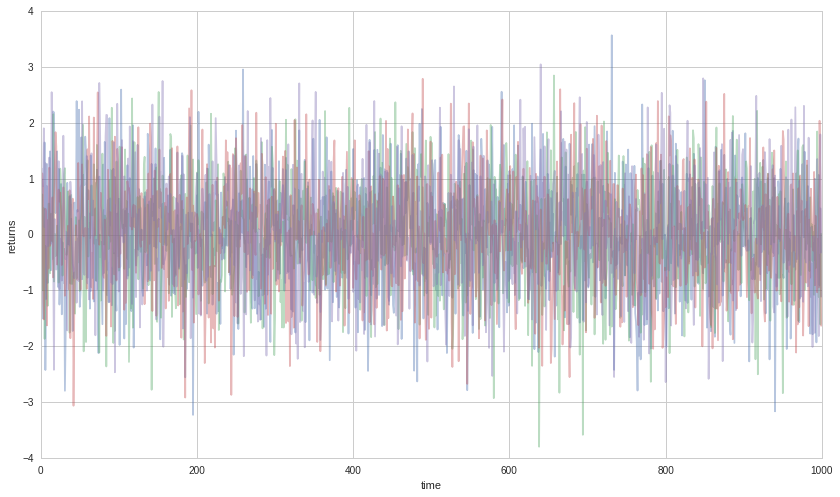

In [3]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns');

Essas séries de retorno podem ser usadas para criar uma ampla gama de portfólios. Produziremos vetores de peso aleatórios e plotaremos esses portfólios. Como queremos que todo o nosso capital seja investido, os pesos terão que somar um.

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


Em seguida, vamos avaliar como esses portfólios aleatórios se sairiam calculando os retornos médios e a volatilidade (aqui estamos usando desvio padrão). Você pode ver que há
um filtro para que plotemos apenas portfólios com desvio padrão de < 2 para melhor ilustração.

In [5]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
        
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

Calculamos o retorno usando

$$ R = p^T w $$

onde $R$ é o retorno esperado, $p^T$ é a transposição do vetor para os retornos médios
para cada série temporal e w é o vetor de peso do portfólio. $p$ é um vetor de coluna $N \vezes 1$
, então $p^T$ turns é um vetor de linha $1 \vezes N$ que pode ser multiplicado pelo vetor de peso (coluna) w
$N \vezes 1$ para dar um resultado escalar. Isso é equivalente ao produto escalar
usado no código. Tenha em mente que `Python` tem uma definição invertida de
linhas e colunas e a versão `NumPy` precisa da equação anterior seria
`R = w * p.T`

Em seguida, calculamos o desvio padrão

$$\sigma = \sqrt{w^T C w}$$

onde $C$ é a matriz de covariância $N \vezes N$ dos retornos. Por favor
observe que se simplesmente calculássemos o desvio padrão simples com a ponderação apropriada usando `std(array(ret_vec).T*w)` obteríamos um
’marcador’ ligeiramente diferente. Isso ocorre porque o cálculo do desvio padrão simples não levaria
as covariâncias em consideração. Na matriz de covariância, os valores na diagonal
representam as variâncias simples de cada ativo, enquanto as entradas fora da diagonal são as variâncias entre os ativos. Ao usar `std()` comum, efetivamente consideramos apenas a
diagonal e perdemos o resto. Uma diferença pequena, mas significativa.

Vamos gerar os retornos médios e a volatilidade para 500 portfólios aleatórios:

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

Ao plotá-los, você observará que eles formam uma forma parabólica característica chamada de "bala de Markowitz", cujo limite superior é chamado de "fronteira eficiente", onde temos a menor variância para um determinado retorno esperado.

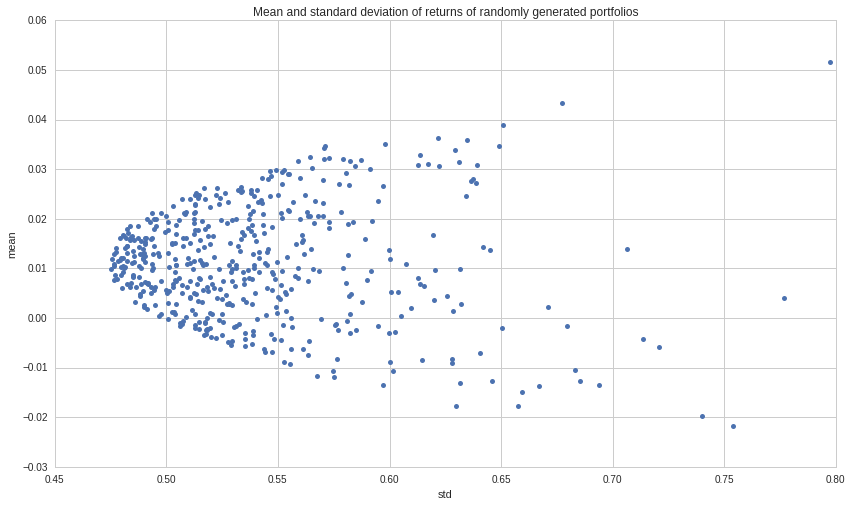

In [ ]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Média e desvio padrão dos retornos de portfólios gerados aleatoriamente');

## Otimização de Markowitz e a Fronteira Eficiente

Agora podemos calcular a fronteira eficiente no estilo Markowitz. Isso é feito minimizando

$$ w^T C w$$

para retorno fixo esperado do portfólio $R^T w$ enquanto mantém a soma de todos os
pesos igual a 1:

$$ \sum_{i}{w_i} = 1 $$

Aqui, executamos parametricamente $R^T w = \mu$ e encontramos a variância mínima
para diferentes $\mu$‘s. Isso pode ser feito com `scipy.optimise.minimize`, mas temos
que definir um problema bastante complexo com limites, restrições e um multiplicador de Lagrange. Convenientemente, o pacote `cvxopt`, um solucionador convexo, faz tudo isso para nós. Usamos um de seus [exemplos]() com algumas modificações, conforme mostrado abaixo. Para obter mais informações sobre como usar este pacote, dê uma olhada no exemplo `cvxopt`.

O vetor `mus` produz uma série não linear de valores de retorno esperados $\mu$, para cada um dos quais encontraremos um portfólio de mínima variância. Veremos mais tarde que não precisamos calcular muitos deles, pois eles se encaixam perfeitamente em uma parábola que pode ser extrapolada com segurança para valores mais altos.

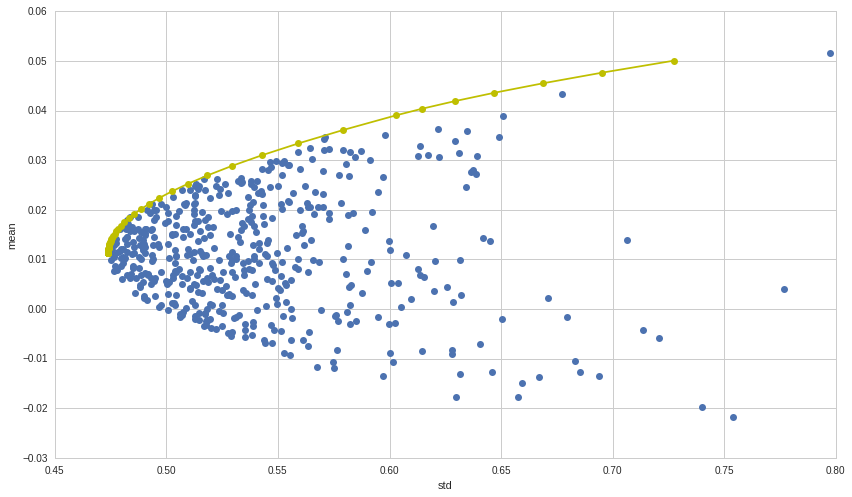

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o');

Em amarelo você pode ver os portfólios ótimos para cada um dos retornos desejados (ou seja, o `mus`). Além disso, obtemos os pesos para um portfólio ótimo:

In [9]:
print weights

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


## Backtesting on real market data

In [10]:
tickers = ['IBM', 'SBUX', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']
data = get_pricing(
    tickers,
    start_date='2005-01-01',
    end_date='2015-01-01'
)

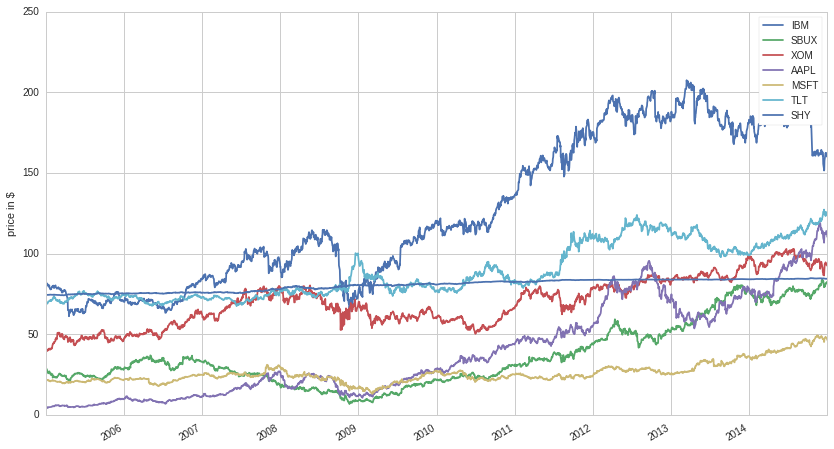

In [11]:
data.loc['price', :, :].plot()
plt.ylabel('price in $')
plt.legend(tickers);

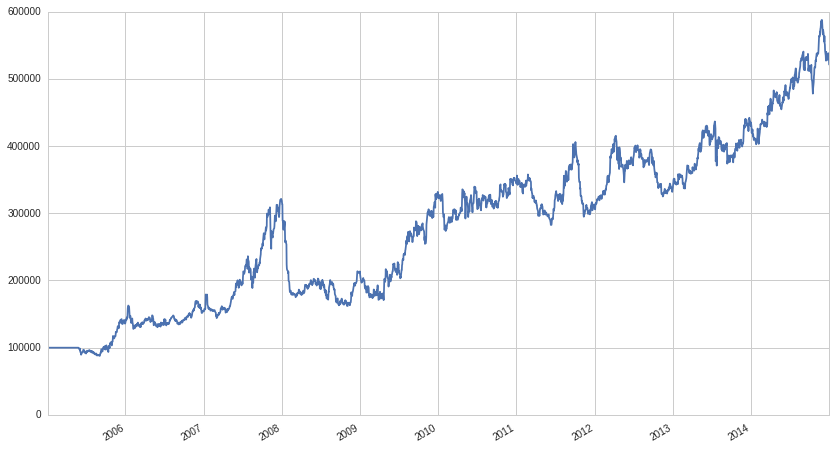

In [ ]:
import zipline
from zipline.api import (
    set_slippage, 
    slippage,
    set_commission, 
    commission, 
    order_target_percent,
    symbols
)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Chamado uma vez no início de um backtest (e negociação ao vivo). 
    Use este método para configurar quaisquer variáveis ​​de contabilidade.

    O objeto de contexto é passado para todos os outros métodos em seu algoritmo.

    Parâmetros

    contexto: Um dicionário Python inicializado e vazio que foi 
    aumentado para que as propriedades possam ser acessadas usando a notação de ponto 
    bem como a notação tradicional de colchetes.

    Retorna Nenhum
    '''
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    context.assets = symbols('IBM', 'SBUX', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY')
    
def handle_data(context, data):
    '''
    Chamado quando um evento de mercado ocorre para qualquer um dos títulos do algoritmo.

    Parâmetros

    dados: Um dicionário codificado por id de segurança contendo o estado atual dos títulos no universo do algoritmo.

    contexto: O mesmo objeto de contexto da função initialize.
    Armazena o portfólio atualizado, bem como quaisquer variáveis ​​de estado definidas.

    Retorna Nenhum
    '''
    
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = data.history(context.assets, 'price', 100, '1d').dropna()
    returns = prices.pct_change().dropna()
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data.swapaxes(2, 0, 1))
results.portfolio_value.plot();

Como você pode ver, o desempenho aqui é muito bom, mesmo durante a crise financeira de 2008. Isso é mais provável devido à nossa seleção de universo e nem sempre deve ser esperado. Aumentar o número de ações no universo pode reduzir a volatilidade também. Por favor, deixe-nos saber na seção de comentários se você teve algum sucesso com esta estratégia e quantas ações você usou.

## Conclusões

Neste blog, coescrito pelo amigo Quantopian [Dr. Thomas Starke](http://drtomstarke.com/), queríamos fornecer uma introdução intuitiva e suave à otimização de portfólio de Markowitz, que ainda permanece relevante hoje. Ao simular vários portfólios aleatórios, vimos que certos portfólios têm melhor desempenho do que outros. A otimização convexa usando `cvxopt` nos permitiu determinar numericamente os portfólios que vivem na *fronteira eficiente*. O backtest de tirolesa serve como exemplo, mas também mostra um desempenho convincente.

## Próximos passos

* Clone este notebook na [Plataforma de Pesquisa Quantopian](http://blog.quantopian.com/quantopian-research-your-backtesting-data-meets-ipython-notebook/) e execute-o você mesmo para ver se consegue melhorar o desempenho. 
* Você também pode baixar apenas o notebook para uso em seu próprio ambiente [aqui]().
* Em uma futura postagem de blog, descreveremos as conexões com a otimização de Kelly, que também nos informa a quantidade de alavancagem a ser usada.
* Adicionamos uma API de otimização que você pode encontrar [aqui](https://www.quantopian.com/posts/optimize-api-now-available-in-algorithms).